### Load Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Process Data

1. **Download** the dataset from [KITTI Evaluation Tracking Dataset](https://www.cvlibs.net/datasets/kitti/eval_tracking.php).

2. **Unzip** the downloaded files to a suitable directory.

3. **Refer** to the README file in the current directory for the sharable links to images and labels.

In [34]:
import os

label_map = {'Van': 0, 'Cyclist': 1, 'Pedestrian': 2, 'Car': 3, 'Truck': 4}

def parse_line(line):
    parts = line.strip().split()
    label = parts[0]
    if label == '-1':
        return None
    category = parts[2]
    if category not in label_map:
        return None
    label_id = label_map[category]
    coordinates = ' '.join(parts[6:16])
    return f"{label_id} {coordinates}\n"

def process_file(input_file, output_folder):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    current_frame = None
    current_lines = []

    for line in lines:
        frame_id = line.strip().split()[0]
        if frame_id != current_frame:
            if current_lines:
                output_file_path = os.path.join(output_folder, f"{current_frame.zfill(6)}.txt")
                with open(output_file_path, 'w') as output_file:
                    output_file.writelines(current_lines)
            current_frame = frame_id
            current_lines = []
        parsed_line = parse_line(line)
        if parsed_line:
            current_lines.append(parsed_line)

    # Write the last frame
    if current_lines:
        output_file_path = os.path.join(output_folder, f"{current_frame.zfill(6)}.txt")
        with open(output_file_path, 'w') as output_file:
            output_file.writelines(current_lines)

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.txt'):
            input_file = os.path.join(input_folder, filename)
            output_subfolder = os.path.join(output_folder, os.path.splitext(filename)[0])
            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)
            process_file(input_file, output_subfolder)

if __name__ == "__main__":
    input_folder = "/content/drive/MyDrive/computer_vision/label_02"
    output_folder = "/content/drive/MyDrive/computer_vision/steps/label_processed"
    process_folder(input_folder, output_folder)


### Check label

In [35]:
!head /content/drive/MyDrive/computer_vision/steps/label_processed/0000/000104.txt

0 811.210616 171.473691 861.176795 220.025036 2.000000 1.823255 4.433886 9.950850 1.971754 32.086805
1 817.104437 172.291945 884.676125 282.923603 1.739063 0.824591 1.785241 4.102372 1.740297 12.320663
0 964.748764 82.119239 1241.000000 374.000000 2.195312 1.895275 5.530314 4.316746 1.768416 5.201357


### Join all the data

In [36]:
import os
import shutil

def combine_folders(images_folder, labels_folder, combined_images_folder, combined_labels_folder):
    if not os.path.exists(combined_images_folder):
        os.makedirs(combined_images_folder)
    if not os.path.exists(combined_labels_folder):
        os.makedirs(combined_labels_folder)

    counter = 0
    for folder_name in sorted(os.listdir(images_folder)):
        images_subfolder = os.path.join(images_folder, folder_name)
        labels_subfolder = os.path.join(labels_folder, folder_name)

        if os.path.isdir(images_subfolder) and os.path.isdir(labels_subfolder):
            for image_file in sorted(os.listdir(images_subfolder)):
                image_path = os.path.join(images_subfolder, image_file)
                label_path = os.path.join(labels_subfolder, image_file.replace('.png', '.txt'))

                if os.path.isfile(image_path) and os.path.isfile(label_path):
                    combined_image_name = str(counter).zfill(6) + ".png"
                    combined_label_name = str(counter).zfill(6) + ".txt"

                    combined_image_path = os.path.join(combined_images_folder, combined_image_name)
                    combined_label_path = os.path.join(combined_labels_folder, combined_label_name)

                    shutil.copyfile(image_path, combined_image_path)
                    shutil.copyfile(label_path, combined_label_path)

                    counter += 1

    print("Combining folders completed.")

if __name__ == "__main__":
    images_folder = "/content/drive/MyDrive/computer_vision/image_02"
    labels_folder = "/content/drive/MyDrive/computer_vision/steps/label_processed"
    combined_images_folder = "/content/drive/MyDrive/computer_vision/steps/image"
    combined_labels_folder = "/content/drive/MyDrive/computer_vision/steps/label"

    combine_folders(images_folder, labels_folder, combined_images_folder, combined_labels_folder)


Combining folders completed.


### Visualize dataset

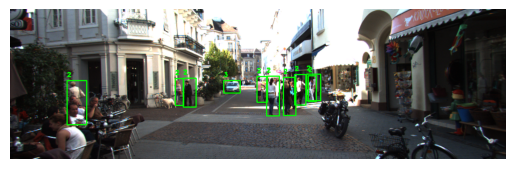

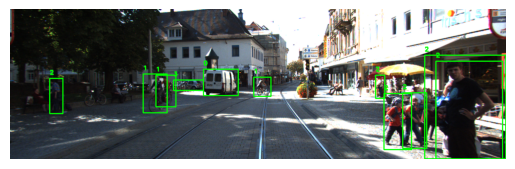

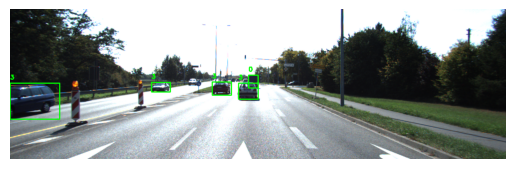

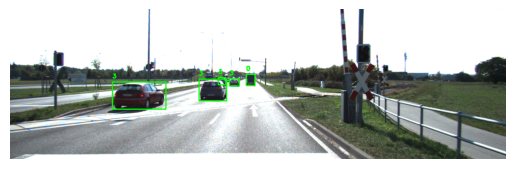

In [37]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def draw_bounding_boxes(image_folder, label_folder, num_images=4):
    image_files = os.listdir(image_folder)
    selected_images = random.sample(image_files, num_images)

    for image_file in selected_images:
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, os.path.splitext(image_file)[0] + ".txt")

        # Read image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read labels
        with open(label_path, 'r') as file:
            lines = file.readlines()

        # Draw bounding boxes
        for line in lines:
            elements = line.strip().split()
            if len(elements) >= 10:
                label = elements[0]
                x_min, y_min, x_max, y_max = map(float, elements[1:5])
                x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display image with bounding boxes
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Replace 'image_folder' and 'label_folder' with your folder paths
image_folder = "/content/drive/MyDrive/computer_vision/steps/image"
label_folder = "/content/drive/MyDrive/computer_vision/steps/label"
draw_bounding_boxes(image_folder, label_folder)


### Check label and image if have the same number of files

In [39]:
import os
import numpy as np

def verify_labels_format(label_folder):
    # Check the format of the labels in the label folder
    for filename in os.listdir(label_folder):
        filepath = os.path.join(label_folder, filename)
        if os.path.isfile(filepath) and filename.endswith('.txt'):
            with open(filepath, 'r') as file:
                for line in file:
                    # Split the line and check if it contains numerical values
                    values = line.strip().split()
                    for value in values[1:]:
                        try:
                            float(value)
                        except ValueError:
                            print(f"Error: Invalid value '{value}' in file '{filename}'")
                            return False
    return True

def preprocess_labels(label_folder):
    # Preprocess the labels if needed
    # In this example, we assume no preprocessing is needed
    pass

def verify_input_data(image_folder, label_folder):
    # Verify the input data (both images and labels)
    for filename in os.listdir(image_folder):
        image_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, filename.replace('.png', '.txt'))
        if not os.path.isfile(label_path):
            print(f"Error: Label file not found for image '{filename}'")
            return False
    return True

# Main function to verify all points
def verify_data(image_folder, label_folder):
    if not verify_labels_format(label_folder):
        return False
    preprocess_labels(label_folder)
    if not verify_input_data(image_folder, label_folder):
        return False
    print("Data verification successful!")
    return True

# Example usage:
image_folder = "/content/drive/MyDrive/computer_vision/steps/image"
label_folder = "/content/drive/MyDrive/computer_vision/steps/label"
verify_data(image_folder, label_folder)


Data verification successful!


True

## Divide the dataset

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define paths
image_dir = "/content/drive/MyDrive/computer_vision/steps/image"
label_dir = "/content/drive/MyDrive/computer_vision/steps/label"

# Define destination directories
train_image_dir = '/content/drive/MyDrive/computer_vision/steps/train/images'
val_image_dir = '/content/drive/MyDrive/computer_vision/steps/val/images'
test_image_dir = '/content/drive/MyDrive/computer_vision/steps/test/images'
train_label_dir = '/content/drive/MyDrive/computer_vision/steps/train/labels'
val_label_dir = '/content/drive/MyDrive/computer_vision/steps/val/labels'
test_label_dir = '/content/drive/MyDrive/computer_vision/steps/test/labels'

# Ensure destination directories exist
for directory in [train_image_dir, val_image_dir, test_image_dir, train_label_dir, val_label_dir, test_label_dir]:
    ensure_directory_exists(directory)

# List all image and label files
all_images = sorted(os.listdir(image_dir))
all_labels = sorted(os.listdir(label_dir))

# Assuming the images and labels have corresponding filenames
assert len(all_images) == len(all_labels), "Mismatch between number of images and labels"

# Split the dataset
train_images, val_test_images, train_labels, val_test_labels = train_test_split(all_images, all_labels, test_size=0.4, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(val_test_images, val_test_labels, test_size=0.5, random_state=42)

# Function to copy files
def copy_files(file_list, src_dir, dest_dir):
    for file in file_list:
        src_file = os.path.join(src_dir, file)
        dest_file = os.path.join(dest_dir, file)
        if os.path.exists(src_file):
            shutil.copy(src_file, dest_file)
        else:
            print(f"Warning: {src_file} does not exist and will not be copied.")

# Copy files to their respective directories
copy_files(train_images, image_dir, train_image_dir)
copy_files(val_images, image_dir, val_image_dir)
copy_files(test_images, image_dir, test_image_dir)

copy_files(train_labels, label_dir, train_label_dir)
copy_files(val_labels, label_dir, val_label_dir)
copy_files(test_labels, label_dir, test_label_dir)

print("Files have been copied successfully.")


Files have been copied successfully.


In [8]:
!ls /content/drive/MyDrive/computer_vision/steps/train/images | wc -l

4050


In [9]:
!ls /content/drive/MyDrive/computer_vision/steps/train/labels | wc -l

4050


In [10]:
import os

# Define directories
train_image_dir = '/content/drive/MyDrive/computer_vision/steps/train/images'
val_image_dir = '/content/drive/MyDrive/computer_vision/steps/val/images'
test_image_dir = '/content/drive/MyDrive/computer_vision/steps/test/images'

train_label_dir = '/content/drive/MyDrive/computer_vision/steps/train/labels'
val_label_dir = '/content/drive/MyDrive/computer_vision/steps/val/labels'
test_label_dir = '/content/drive/MyDrive/computer_vision/steps/test/labels'

# Function to count files in a directory
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Count files in each directory
train_image_count = count_files(train_image_dir)
val_image_count = count_files(val_image_dir)
test_image_count = count_files(test_image_dir)

train_label_count = count_files(train_label_dir)
val_label_count = count_files(val_label_dir)
test_label_count = count_files(test_label_dir)

# Print the results
print(f"Number of training images: {train_image_count}")
print(f"Number of validation images: {val_image_count}")
print(f"Number of test images: {test_image_count}")

print(f"Number of training labels: {train_label_count}")
print(f"Number of validation labels: {val_label_count}")
print(f"Number of test labels: {test_label_count}")


Number of training images: 4050
Number of validation images: 1350
Number of test images: 1350
Number of training labels: 4050
Number of validation labels: 1350
Number of test labels: 1350


In [21]:
!head /content/drive/MyDrive/computer_vision/dataset/train/labels/006749.txt

head: cannot open '/content/drive/MyDrive/computer_vision/dataset/train/labels/006749.txt' for reading: No such file or directory


In [12]:
import os

# Function to truncate labels to the first five values
def truncate_label_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    truncated_lines = []
    for line in lines:
        # Split the line into individual values
        values = line.strip().split()
        # Keep only the first five values
        truncated_values = values[:5]
        # Join the values back into a single string
        truncated_line = ' '.join(truncated_values)
        truncated_lines.append(truncated_line)

    # Write the truncated lines back to the file
    with open(file_path, 'w') as file:
        file.write('\n'.join(truncated_lines) + '\n')

# Define directories
label_dirs = [
    '/content/drive/MyDrive/computer_vision/steps/train/labels',
    '/content/drive/MyDrive/computer_vision/steps/val/labels',
    '/content/drive/MyDrive/computer_vision/steps/test/labels'
]

# Apply truncation to all label files in the directories
for label_dir in label_dirs:
    for label_file in os.listdir(label_dir):
        label_file_path = os.path.join(label_dir, label_file)
        truncate_label_file(label_file_path)

print("Labels have been truncated to the first five values.")


Labels have been truncated to the first five values.


In [2]:
!head /content/drive/MyDrive/computer_vision/steps/train/labels/000025.txt

0 305.921995 170.196348 412.563625 267.892887
1 679.098134 172.161527 861.069880 373.778511
0 529.274100 170.342959 623.430721 218.578921


## Normalize dataset for impletation using yolov5

In [3]:
import os
from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.size  # returns (width, height)

def normalize_labels(input_label_dir, output_label_dir, image_dir):
    # Ensure the output directory exists
    os.makedirs(output_label_dir, exist_ok=True)

    for label_file in os.listdir(input_label_dir):
        if label_file.endswith(".txt"):
            input_label_path = os.path.join(input_label_dir, label_file)
            output_label_path = os.path.join(output_label_dir, label_file)

            # Get the corresponding image dimensions
            image_filename = label_file.replace(".txt", ".png")  # Assumes images are in .png format
            image_path = os.path.join(image_dir, image_filename)
            ref_width, ref_height = get_image_dimensions(image_path)

            with open(input_label_path, 'r') as file:
                lines = file.readlines()

            normalized_lines = []
            for line in lines:
                parts = line.strip().split()
                class_id = parts[0]
                x_min = float(parts[1])
                y_min = float(parts[2])
                x_max = float(parts[3])
                y_max = float(parts[4])

                # Calculate x_center, y_center, width, height
                x_center = (x_min + x_max) / 2.0
                y_center = (y_min + y_max) / 2.0
                width = x_max - x_min
                height = y_max - y_min

                # Normalize based on the image's width and height
                normalized_x = x_center / ref_width
                normalized_y = y_center / ref_height
                normalized_w = width / ref_width
                normalized_h = height / ref_height

                normalized_lines.append(f"{class_id} {normalized_x:.15f} {normalized_y:.15f} {normalized_w:.15f} {normalized_h:.15f}\n")

            # Write the normalized values to the output directory
            with open(output_label_path, 'w') as file:
                file.writelines(normalized_lines)

In [ ]:
# Replace with your actual paths
input_label_dir = '/content/drive/MyDrive/computer_vision/steps/train/labels'
output_label_dir = '/content/drive/MyDrive/computer_vision/steps/train/labels_02'
image_dir = '/content/drive/MyDrive/computer_vision/steps/train/images'

normalize_labels(input_label_dir, output_label_dir, image_dir)

In [ ]:
input_label_dir = '/content/drive/MyDrive/computer_vision/steps/val/labels'
output_label_dir = '/content/drive/MyDrive/computer_vision/steps/val/labels_02'
image_dir = '/content/drive/MyDrive/computer_vision/steps/val/images'

normalize_labels(input_label_dir, output_label_dir, image_dir)

## Due to limited resources training only with 600 images

In [ ]:
import os
import random
import shutil

# Set the random seed for reproducibility
random.seed(42)

# Define the paths to the image and label folders
label_folder = '/content/drive/MyDrive/computer_vision/steps/val/labels_02'
image_folder = '/content/drive/MyDrive/computer_vision/steps/val/images'

# Define the output folders for the selected pairs
output_label_folder = '/content/drive/MyDrive/computer_vision/dataset/val/labels'
output_image_folder = '/content/drive/MyDrive/computer_vision/dataset/val/images'

# Create the output folders if they don't exist
os.makedirs(output_image_folder, exist_ok=True)
os.makedirs(output_label_folder, exist_ok=True)

# Get the list of image files (only .png files)
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# Randomly select 500 image files
selected_images = random.sample(image_files, 150)

# Copy the selected images and their corresponding labels to the output folders
for image_file in selected_images:
    # Determine the corresponding label file name
    label_file = image_file.replace('.png', '.txt')

    # Define full paths to the source and destination files
    src_image_path = os.path.join(image_folder, image_file)
    src_label_path = os.path.join(label_folder, label_file)
    dest_image_path = os.path.join(output_image_folder, image_file)
    dest_label_path = os.path.join(output_label_folder, label_file)

    # Copy the image and label to the output folders
    shutil.copy(src_image_path, dest_image_path)
    shutil.copy(src_label_path, dest_label_path)

In [ ]:
import os
import random
import shutil

# Set the random seed for reproducibility
random.seed(42)

# Define the paths to the image and label folders
label_folder = '/content/drive/MyDrive/computer_vision/steps/train/labels_02'
image_folder = '/content/drive/MyDrive/computer_vision/steps/train/images'

# Define the output folders for the selected pairs
output_label_folder = '/content/drive/MyDrive/computer_vision/dataset/train/labels'
output_image_folder = '/content/drive/MyDrive/computer_vision/dataset/train/images'

# Create the output folders if they don't exist
os.makedirs(output_image_folder, exist_ok=True)
os.makedirs(output_label_folder, exist_ok=True)

# Get the list of image files (only .png files)
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# Randomly select 650 image files
selected_images = random.sample(image_files, 650)

# Copy the selected images and their corresponding labels to the output folders
for image_file in selected_images:
    # Determine the corresponding label file name
    label_file = image_file.replace('.png', '.txt')

    # Define full paths to the source and destination files
    src_image_path = os.path.join(image_folder, image_file)
    src_label_path = os.path.join(label_folder, label_file)
    dest_image_path = os.path.join(output_image_folder, image_file)
    dest_label_path = os.path.join(output_label_folder, label_file)

    # Check if the label file exists before copying
    if os.path.exists(src_label_path):
        # Copy the image and label to the output folders
        shutil.copy(src_image_path, dest_image_path)
        shutil.copy(src_label_path, dest_label_path)
    else:
        print(f"Label file not found for {image_file}. Skipping this pair.")

In [ ]:
!head /content/drive/MyDrive/computer_vision/dataset/train/labels/000025.txt

### Label destribution

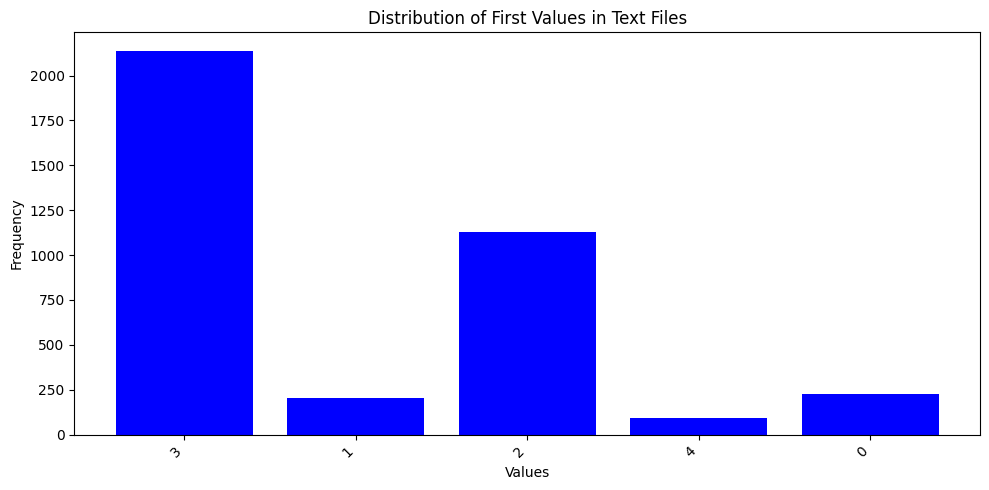

In [28]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def read_first_values_from_files(folder_path):
    first_values = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                for line in file:
                    first_value = line.split()[0]  # Assuming values are space-separated
                    first_values.append(first_value)
    return first_values

def plot_distribution(first_values):
    # Count the occurrences of each value
    value_counts = Counter(first_values)

    # Separate the keys and values for plotting
    keys = list(value_counts.keys())
    values = list(value_counts.values())

    # Create the bar graph
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color='blue')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of First Values in Text Files')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def main(folder_path):
    first_values = read_first_values_from_files(folder_path)
    plot_distribution(first_values)


folder_path = '/content/drive/MyDrive/computer_vision/dataset/train/labels'
main(folder_path)

